In [25]:
from Bio import SeqIO
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

%matplotlib inline

### Evaluate the time difference req'd to run minimap2 against the initial v. new .fasta file

In [26]:
# take the outputs of experiment-4 -- {this_dump}.fasta and {this_dump}.new.fasta -- and use these
# this cell will maintain parity with the dumps generated for experiment-4

#this_dump = "../experiment-4/moraxellacatarhalis_29497_dump"
#this_dump = "../experiment-4/chkv_txid37124_dump"
#this_dump = "../experiment-4/rhinovirusc_463676_dump"
this_dump = "../experiment-4/candidaauris_498019_dump"

# additionally, set a reference genome from which to simulate reads for this organism
#this_genome = "refs_to_simulate_reads_from/moraxellacatarhalis_NZ_CP018059.fasta"
#this_genome = "refs_to_simulate_reads_from/chikungunya_virus_NC_004162.2.fasta"
#this_genome = "refs_to_simulate_reads_from/rhinovirus_c_NC_038878.1.fasta"
this_genome = "refs_to_simulate_reads_from/GCF_002775015.1_Cand_auris_B11221_V1_genomic.fasta"

In [27]:
def mutate_sequence(sequence, pid):
    '''
    Given a sequence and a % ID threshold, mutate the sequence at random positions to produce
    a new sequence with the specified % ID. Return the new sequence string.
    '''
    
    swap_values = ['A','C','G','T']
    
    len_of_seq = len(sequence)
    num_bp_to_change = (np.round(len_of_seq) * (1-pid))
    all_bp_locs = [b for b in range(len_of_seq)]    
    bp_locs_to_change = random.sample(all_bp_locs, int(num_bp_to_change))
    
    # loop through indices of bases to change and swap out values
    new_seq = list(sequence)
    for bp in bp_locs_to_change:
        new_seq[bp] = random.sample([i for i in swap_values if i != new_seq[bp] ], 1)[0]
        
    return("".join(new_seq))

# generate a genome that is slightly different from anything in the DB already (99.8% similar to the reference)
records = list(SeqIO.parse(this_genome, "fasta"))         # read in the genome file
seq_to_simulate = mutate_sequence(records[0].seq, .998)   # mutate the sequence

# write the new genome output
with open("simulation_reference.fasta", 'w') as f: 
    f.write('>' + records[0].id + ' -- mutated\n' + str(seq_to_simulate) + '\n')
f.close()

In [28]:
# simulate sequences from the input file using InSilicoSeq
max_size = 100000
! iss generate --genomes simulation_reference.fasta --model miseq --output miseq_reads --n_reads {max_size}

INFO:iss.app:Starting iss generate
INFO:iss.app:Using kde ErrorModel
INFO:iss.util:Stitching input files together
INFO:iss.app:Using lognormal abundance distribution
INFO:iss.app:Using 2 cpus for read generation
INFO:iss.app:Generating 100000 reads
INFO:iss.app:Generating reads for record: NW_021640165.1
INFO:iss.util:Stitching input files together
INFO:iss.util:Stitching input files together
INFO:iss.util:Cleaning up
INFO:iss.app:Read generation complete


In [29]:
# pseudo-simulate 1 million reads by just 10x-ing the 100,000 simulated reads
! cat miseq_reads_R1.fastq miseq_reads_R1.fastq miseq_reads_R1.fastq miseq_reads_R1.fastq miseq_reads_R1.fastq miseq_reads_R1.fastq miseq_reads_R1.fastq miseq_reads_R1.fastq miseq_reads_R1.fastq miseq_reads_R1.fastq > miseq_reads_10x_R1.fastq
! mv miseq_reads_10x_R1.fastq miseq_reads_R1.fastq
! cat miseq_reads_R2.fastq miseq_reads_R2.fastq miseq_reads_R2.fastq miseq_reads_R2.fastq miseq_reads_R2.fastq miseq_reads_R2.fastq miseq_reads_R2.fastq miseq_reads_R2.fastq miseq_reads_R2.fastq miseq_reads_R2.fastq > miseq_reads_10x_R2.fastq
! mv miseq_reads_10x_R2.fastq miseq_reads_R2.fastq

In [30]:
max_size = 1000000

In [31]:
metric_collection = {}

simulated_input_sizes = [1000, 10000, 100000]#, 1000000]
total_iterations = 5

# attempt to speed things up by creating the index just once at the outset
this_dump_fasta = this_dump + '.fasta'
! minimap2 -x sr -d ref_orig.mmi {this_dump_fasta} 
new_dump_fasta = this_dump + '.new.fasta'
! minimap2 -x sr -d ref_clustered.mmi {new_dump_fasta} 
        

for input_size in simulated_input_sizes:
    print("INPUT SIZE: " + str(input_size))

    metric_collection[input_size] = {'original_time': [], 'clustered_time': [], 'timediffx': [], 
                                     'original_unmapped_reads': [], 'clustered_unmapped_reads': [], 'unmapped_diff': []}

    print("generating subset data...")
    if(input_size < max_size):
        ! seqkit sample -s100 -n {input_size} miseq_reads_R1.fastq -o sub1.fastq
        ! seqkit sample -s100 -n {input_size} miseq_reads_R2.fastq -o sub2.fastq
    else:
        ! cp miseq_reads_R1.fastq sub1.fastq
        ! cp miseq_reads_R2.fastq sub2.fastq
    
    print("completed generating subset data")
    for i in range(total_iterations):
        
        print("ITERATION: " + str(i))

        # map to original dump
        #this_dump_fasta = this_dump + '.fasta'
        #! minimap2 -ax sr {this_dump_fasta} miseq_reads_R1.fastq miseq_reads_R2.fastq > aln.sam
        # separate indexing from alignment time
        #print("CREATING INDEX")
        #! minimap2 -x sr -d ref.mmi {this_dump_fasta} 
        print("RUNNING ALIGNMENT")
        start = time.time()  # start after indexing, but before alignment
        ! minimap2 -ax sr ref_orig.mmi sub1.fastq sub2.fastq > aln.sam
        end = time.time()   # end directly after alignment to capture ONLY alignment time
        print("ALIGNMENT COMPLETE, collecting stats")
        ! samtools stats aln.sam > alnstats.txt
        unmapped_reads_string = ! grep "reads unmapped:" alnstats.txt
        orig_unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())    
        orig_elapsed = end - start
        print('\n\n')
        print("unmapped_reads_count: " + str(orig_unmapped_reads_count))
        print("time elapsed: " + str(orig_elapsed))
        print('\n\n')


        # map to clustered dump
        #new_dump_fasta = this_dump + '.new.fasta'
        #! minimap2 -ax sr {new_dump_fasta} miseq_reads_R1.fastq miseq_reads_R2.fastq > aln.sam
        # separate indexing from alignment time
        #print("CREATING INDEX")
        #! minimap2 -x sr -d ref.mmi {new_dump_fasta} 
        print("RUNNING ALIGNMENT")
        start = time.time()  # start after indexing, but before alignment
        ! minimap2 -ax sr ref_clustered.mmi sub1.fastq sub2.fastq > aln.sam
        end = time.time()   # end directly after alignment to capture ONLY alignment time
        print("ALIGNMENT COMPLETE, collecting stats")
        ! samtools stats aln.sam > alnstats.txt
        unmapped_reads_string = ! grep "reads unmapped:" alnstats.txt
        unmapped_reads_count = int(unmapped_reads_string[0].split(':')[-1].strip())
        elapsed = end - start

        print('\n\n')
        print("unmapped_reads_count: " + str(unmapped_reads_count))
        print("time elapsed: " + str(elapsed))
        print('\n\n')
    
        
        metric_collection[input_size]['original_time'].append(orig_elapsed)
        metric_collection[input_size]['clustered_time'].append(elapsed)
        metric_collection[input_size]['original_unmapped_reads'].append(orig_unmapped_reads_count)
        metric_collection[input_size]['clustered_unmapped_reads'].append(unmapped_reads_count)
        metric_collection[input_size]['timediffx'].append(orig_elapsed/elapsed)
        metric_collection[input_size]['unmapped_diff'].append((orig_unmapped_reads_count - unmapped_reads_count)/input_size)
        
        

[M::mm_idx_gen::10.836*1.61] collected minimizers
[M::mm_idx_gen::12.280*1.77] sorted minimizers
[M::main::14.661*1.60] loaded/built the index for 8585 target sequence(s)
[M::mm_idx_stat] kmer size: 21; skip: 11; is_hpc: 0; #seq: 8585
[M::mm_idx_stat::14.706*1.60] distinct minimizers: 3519889 (20.33% are singletons); average occurrences: 30.504; average spacing: 5.985; total length: 642562911
[M::main] Version: 2.22-r1101
[M::main] CMD: minimap2 -x sr -d ref_orig.mmi ../experiment-4/candidaauris_498019_dump.fasta
[M::main] Real time: 15.019 sec; CPU: 23.879 sec; Peak RSS: 2.941 GB
[M::mm_idx_gen::1.042*1.01] collected minimizers
[M::mm_idx_gen::1.187*1.25] sorted minimizers
[M::main::1.585*1.14] loaded/built the index for 3796 target sequence(s)
[M::mm_idx_stat] kmer size: 21; skip: 11; is_hpc: 0; #seq: 3796
[M::mm_idx_stat::1.621*1.14] distinct minimizers: 3097147 (36.01% are singletons); average occurrences: 2.528; average spacing: 5.993; total length: 46926166
[M::main] Version: 2.2

ALIGNMENT COMPLETE, collecting stats



unmapped_reads_count: 0
time elapsed: 0.571997880935669



INPUT SIZE: 10000
generating subset data...
[INFO] sample by number
[INFO] loading all sequences into memory...
[INFO] 9979 sequences outputted
[INFO] sample by number
[INFO] loading all sequences into memory...
[INFO] 9979 sequences outputted
completed generating subset data
ITERATION: 0
RUNNING ALIGNMENT
[M::main::0.937*1.02] loaded/built the index for 8585 target sequence(s)
[M::mm_mapopt_update::0.937*1.02] mid_occ = 1000
[M::mm_idx_stat] kmer size: 21; skip: 11; is_hpc: 0; #seq: 8585
[M::mm_idx_stat::0.982*1.02] distinct minimizers: 3519889 (20.33% are singletons); average occurrences: 30.504; average spacing: 5.985; total length: 642562911
[M::worker_pipeline::4.357*2.51] mapped 19958 sequences
[M::main] Version: 2.22-r1101
[M::main] CMD: minimap2 -ax sr ref_orig.mmi sub1.fastq sub2.fastq
[M::main] Real time: 4.653 sec; CPU: 11.247 sec; Peak RSS: 1.299 GB
ALIGNMENT COMPLETE, collect

ALIGNMENT COMPLETE, collecting stats



unmapped_reads_count: 6
time elapsed: 36.96136713027954



RUNNING ALIGNMENT
[M::main::0.289*1.08] loaded/built the index for 3796 target sequence(s)
[M::mm_mapopt_update::0.289*1.08] mid_occ = 1000
[M::mm_idx_stat] kmer size: 21; skip: 11; is_hpc: 0; #seq: 3796
[M::mm_idx_stat::0.326*1.07] distinct minimizers: 3097147 (36.01% are singletons); average occurrences: 2.528; average spacing: 5.993; total length: 46926166
[M::worker_pipeline::6.808*2.91] mapped 166114 sequences
[M::worker_pipeline::7.608*2.89] mapped 33886 sequences
[M::main] Version: 2.22-r1101
[M::main] CMD: minimap2 -ax sr ref_clustered.mmi sub1.fastq sub2.fastq
[M::main] Real time: 7.624 sec; CPU: 22.018 sec; Peak RSS: 0.375 GB
ALIGNMENT COMPLETE, collecting stats



unmapped_reads_count: 6
time elapsed: 7.777756929397583



ITERATION: 1
RUNNING ALIGNMENT
[M::main::0.929*1.03] loaded/built the index for 8585 target sequence(s)
[M::mm_mapopt_update::0.929*1.03] mid_occ = 1000
[M::m

In [32]:
print(metric_collection)

{1000: {'original_time': [1.9141030311584473, 1.952448844909668, 2.172839879989624, 2.0001890659332275, 1.8331749439239502], 'clustered_time': [0.5666799545288086, 0.5934360027313232, 0.5411460399627686, 0.5277020931243896, 0.571997880935669], 'timediffx': [3.37774967309372, 3.2900748116450806, 4.015255992890787, 3.7903754637216194, 3.2048631734880892], 'original_unmapped_reads': [0, 0, 0, 0, 0], 'clustered_unmapped_reads': [0, 0, 0, 0, 0], 'unmapped_diff': [0.0, 0.0, 0.0, 0.0, 0.0]}, 10000: {'original_time': [4.842766761779785, 5.506072044372559, 5.515480995178223, 5.152024984359741, 5.0707128047943115], 'clustered_time': [1.2486109733581543, 1.2205166816711426, 1.2675037384033203, 1.292954921722412, 1.1437082290649414], 'timediffx': [3.8785233071875904, 4.511263243721991, 4.351451461694383, 3.984690338234269, 4.433572021196316], 'original_unmapped_reads': [0, 0, 0, 0, 0], 'clustered_unmapped_reads': [0, 0, 0, 0, 0], 'unmapped_diff': [0.0, 0.0, 0.0, 0.0, 0.0]}, 100000: {'original_time

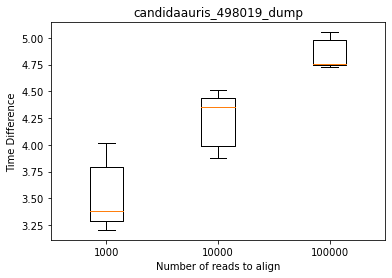

In [33]:
# FOR FUTURE USE -- MAKE A BOXPLOR OF THE metric_collection data

time_dict = dict(zip(simulated_input_sizes, [metric_collection[i]['timediffx'] for i in simulated_input_sizes]))

labels, data = time_dict.keys(), time_dict.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel('Time Difference')
plt.xlabel('Number of reads to align')
plt.title(this_dump.split('/')[-1])
plt.show()


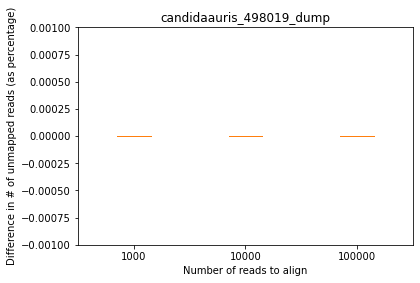

In [34]:
# FOR FUTURE USE -- MAKE A BOXPLOR OF THE metric_collection data

time_dict = dict(zip(simulated_input_sizes, [metric_collection[i]['unmapped_diff'] for i in simulated_input_sizes]))

labels, data = time_dict.keys(), time_dict.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel('Difference in # of unmapped reads (as percentage)')
plt.xlabel('Number of reads to align')
plt.ylim(-.001,.001)
plt.title(this_dump.split('/')[-1])
plt.show()


{1000: [0, 0, 0, 0, 0], 10000: [0, 0, 0, 0, 0], 100000: [0, 0, 0, 0, 0]}


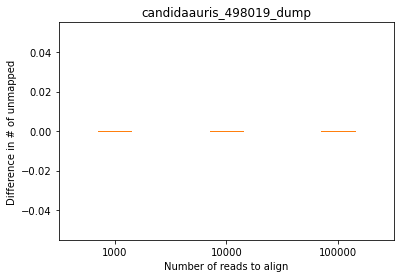

In [35]:
# FOR FUTURE USE -- MAKE A BOXPLOR OF THE metric_collection data

time_dict = dict(zip(simulated_input_sizes, [[metric_collection[i]['original_unmapped_reads'][j] - metric_collection[i]['clustered_unmapped_reads'][j] for j in range(total_iterations)] for i in simulated_input_sizes]))

print(time_dict)
labels, data = time_dict.keys(), time_dict.values()

plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel('Difference in # of unmapped')
plt.xlabel('Number of reads to align')
plt.title(this_dump.split('/')[-1])
plt.show()
